# Smart Building Energy Forecasting: Identifying Behavioral vs Climate Load Drivers

## 1.Project Overview
The goal of this project is to analyze how outdoor weather conditions (temperature, humidity) relate to appliance-level energy consumption in a residential building and to evaluare whether weather can be used to **reliably forecast energy demand** for smart-city resource optimization.

The project focuses on three main questions:

1. How is appliance energy consumption distributed over time (daily and monthly patterns)?
    
2. To what extent does outside temperature and humidity explain variation in energy use?
    
3. Can a simple predictive model based on weather features forecast daily appliance energy usage with useful accuracy?

## 2.Data Description
### 2.1 Source
- **Dataset:** Appliances Energy Prediction Data Set
- **Provider:** UCI Machine Learning Repository
- **Original file:** energydata_complete.csv
- **Granularity:** 10-minute interval measurements

### 2.2 Key Variables Used
From the original dataset:
- **date:** Timestamp of the measurement (10-minute frequency)
- **Appliances:** Energy use of appliances (Wh)- **target variable**
- **T_out:** Outside temperature(°C)
- **RH_out:** Outside relative humidity(%)

Other internal temperature/humidity variables were available but not central to the main questions, so the analysis primarily focuses on:
- **Energy consumption:** Appliances
- **Weather features:** T_out, RH_out

## 3.Data Processing & SQL Modeling
### 3.1 Logical Data Model
For demonstration of SQL and multi-source style modeling, the original CSV was split into two logical tables and stored in a SQLite database (smart_city.db):

1. energy_consumption
   - date (DATETIME)
   - appliances_energy (REAL)- renamed from Appliances
   - optional: lights, internal temperatures T1-T9, etc

2. weather
    - date (DATETIME)
    - T_out (REAL)- outside temperature
    - RH_out (REAL)- outside humidity
    - Press_mm_hg (REAL)- pressure (not used in final model)
    - Windspeed (REAL)- wind speed (not used in final model)
The join key between the two tables is the **Timestamp** date

### 3.2 Loading and Splitting Data in Python

In [8]:
import pandas as pd
import sqlite3

df = pd.read_csv('../Data/energydata_complete.csv')

df_energy = df[['date', 'Appliances']].rename(columns={'Appliances': 'appliances_energy'})
df_weather = df[['date', 'T_out', 'RH_out', 'Press_mm_hg', 'Windspeed']].rename(
    columns={'Press_mm_hg': 'Press_mmHg'}
)

conn = sqlite3.connect('smart_city.db')
df_energy.to_sql('energy_consumption', conn, if_exists='replace', index=False)
df_weather.to_sql('weather', conn, if_exists='replace', index=False)

19735

## 3.3 SQL Join and Aggregation

In [4]:
# Python code for joining SQL Table

query = """
SELECT 
    e.date,
    e.appliances_energy,
    w.T_out,
    w.RH_out
FROM energy_consumption e
JOIN weather w ON e.date = w.date
"""
df_viz = pd.read_sql_query(query, conn)
df_viz['date'] = pd.to_datetime(df_viz['date'])

## 4.Feature Engineering & Aggregation
### 4.1 Daily Aggregation
To reduce noise from 10-minute measurements and focus on daily behavior, the data was aggregated to the **daily level:**


In [5]:
df_viz['day'] = df_viz['date'].dt.date

df_daily = (
    df_viz
    .groupby('day')
    .agg(
        avg_daily_energy=('appliances_energy', 'mean'),
        avg_daily_temp=('T_out', 'mean'),
        avg_daily_humidity=('RH_out', 'mean')
    )
    .reset_index()
)

df_daily['day'] = pd.to_datetime(df_daily['day'])

This produced one row per day (138 rows), with:

- avg_daily_energy (Wh)
- avg_daily_temp (°C)
- avg_daily_humidity (%)

### 4.2 Monthly Aggregation (for Trend Analysis)
Monthly averages were also computed to analyse seasonality:

In [6]:
df_daily['year_month'] = df_daily['day'].dt.to_period('M')

df_monthly = (
    df_daily
    .groupby('year_month')
    .agg(
        avg_energy=('avg_daily_energy', 'mean'),
        avg_temp=('avg_daily_temp', 'mean'),
        avg_humidity=('avg_daily_humidity', 'mean')
    )
    .reset_index()
)
df_monthly['year_month'] = df_monthly['year_month'].dt.to_timestamp()

## 5. Exploratory Data Analysis
### 5.1 Daily Energy vs Temperature
A scatter plot of daily mean energy vs. daily mean temperature shows a diffuse cloud of points with no clear trend.

Interpretation:
- Energy consumption ranges roughly from ~60 to ~160 Wh per day.
- Temperatures range from roughly -2°C to ~ 20°C.
- There is **no strong linear relationship** visile by eye.

This visual supports the hypothesis that **appliance energy is not strongly driven by outdoor temperature**.

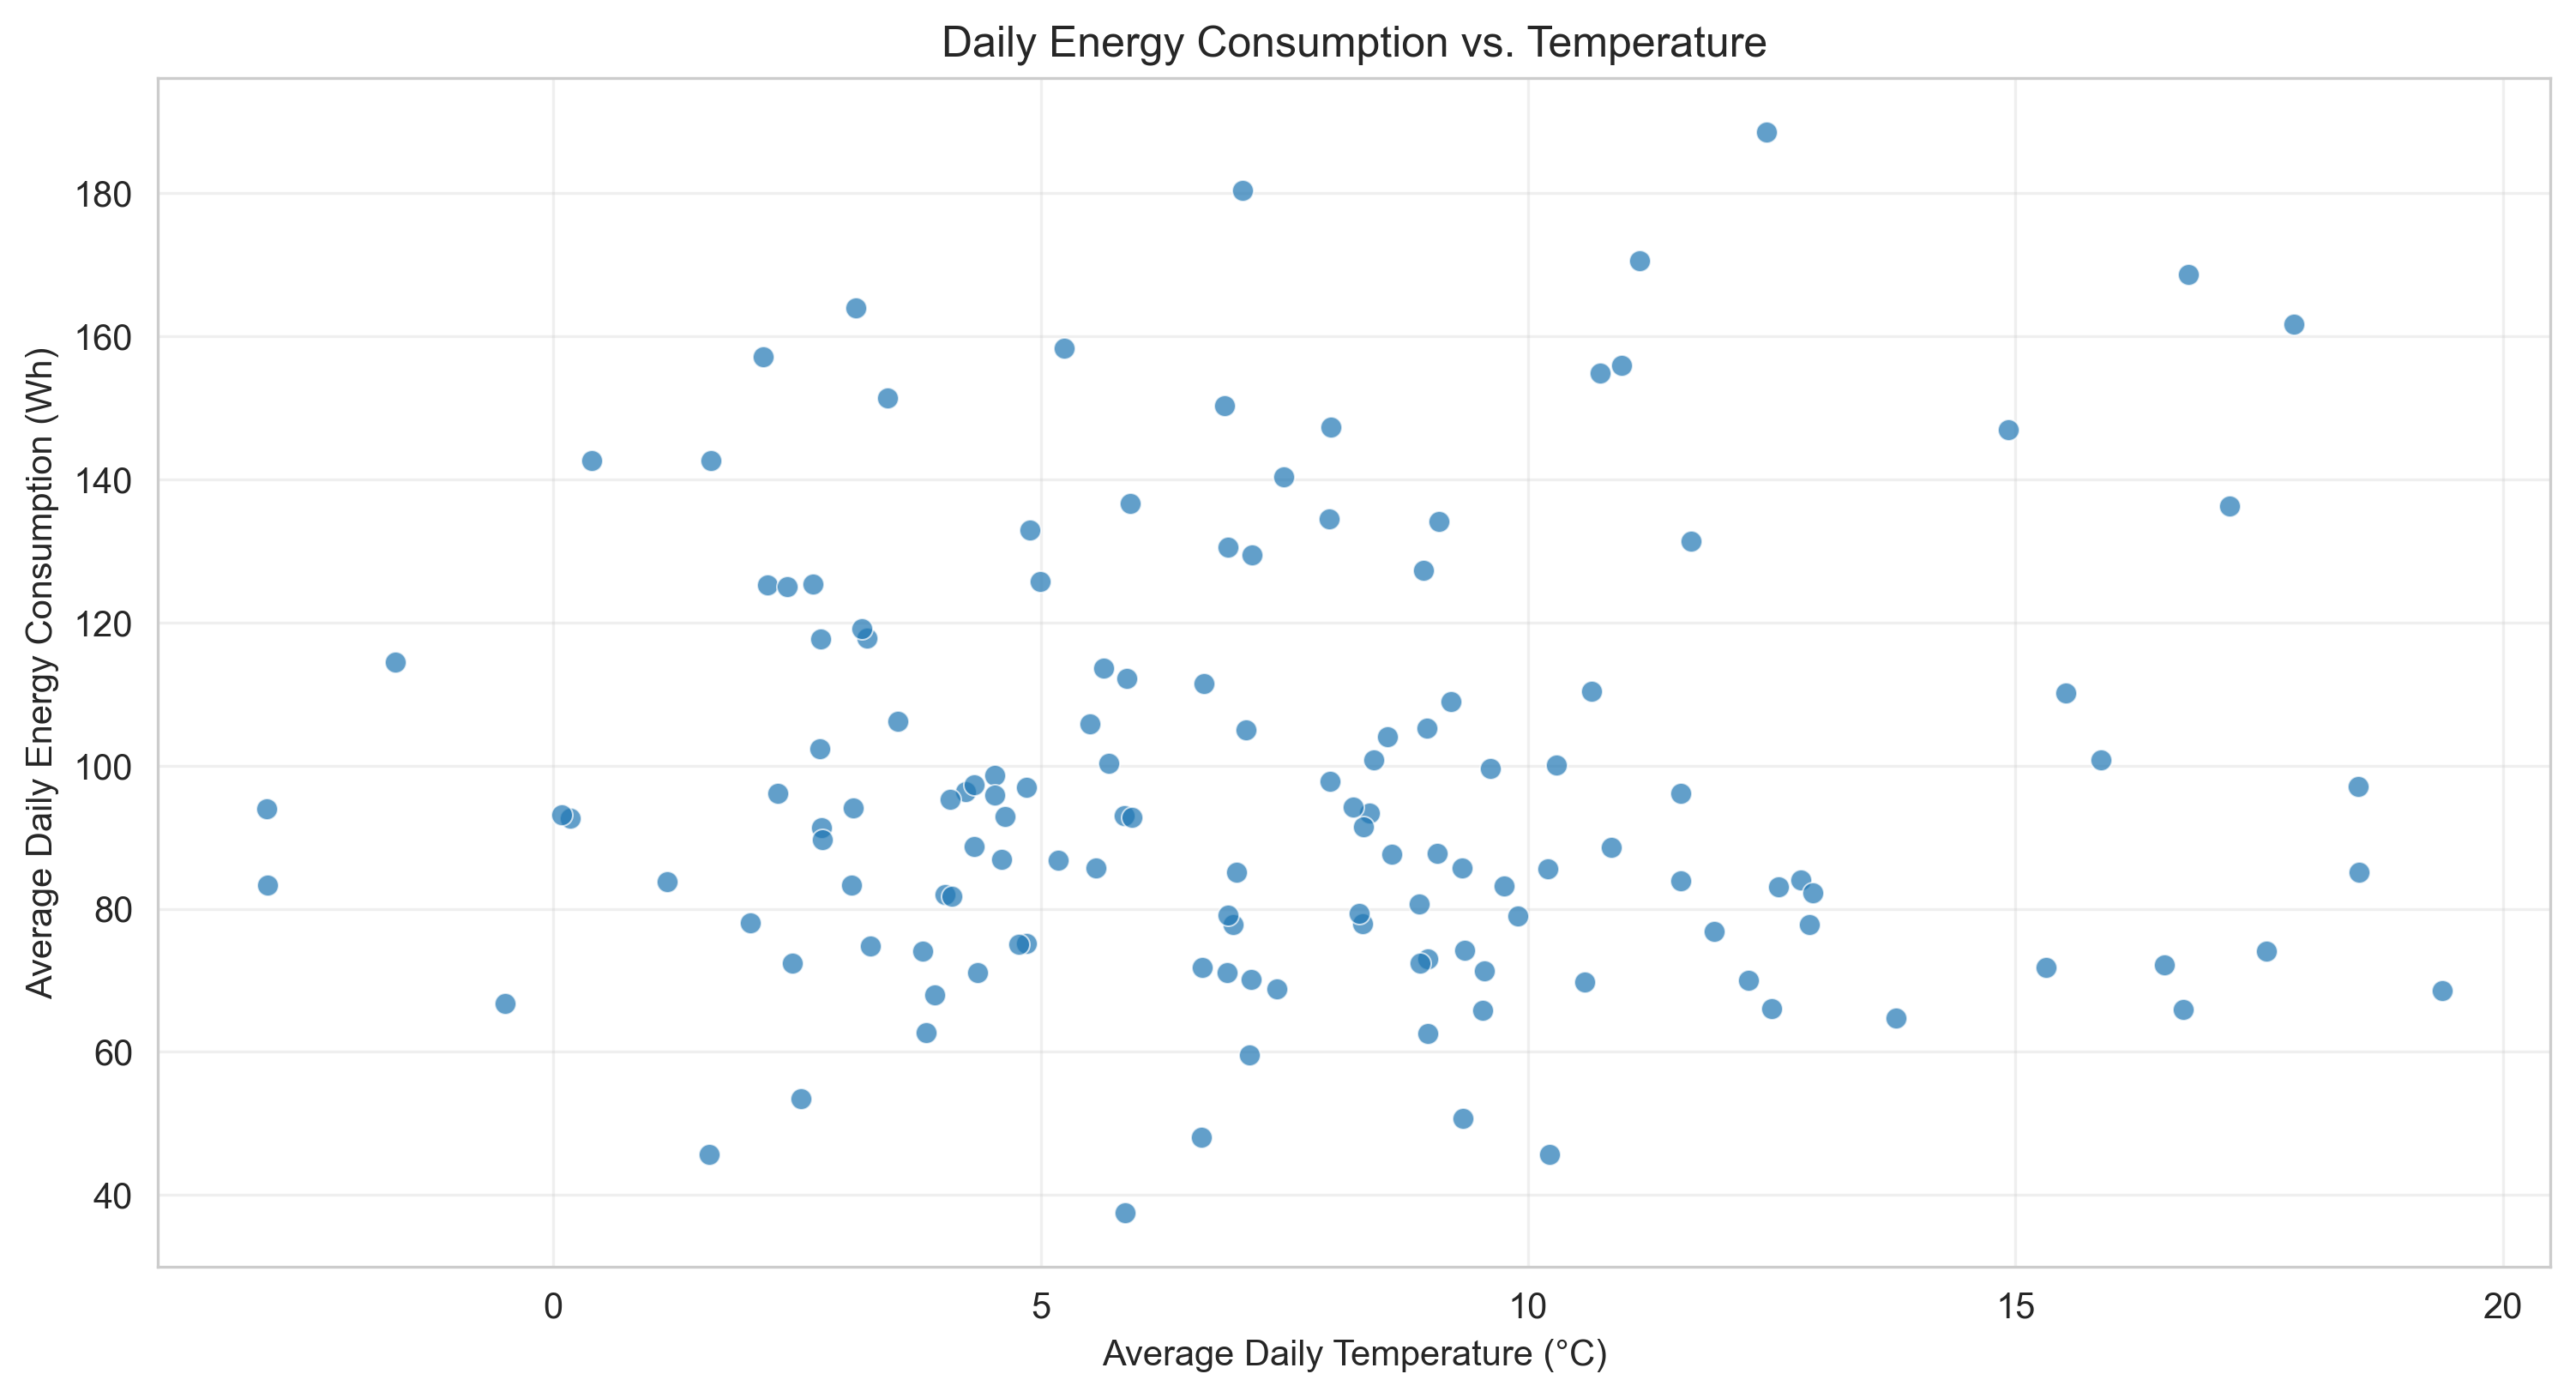

### 5.2 Monthly Energy Trends
A line chart of avg_energy by month shows:
- Highest average energy in **February**, lowest in **April**, following colder weather patterns.
- Vairation between months is relatively small (on the order of ~60-155 Wh daily averages).
- Pattern roughly follows colder vs. milder months, but the magnitude of variation is limited. This hints that weather plays only a modest role.

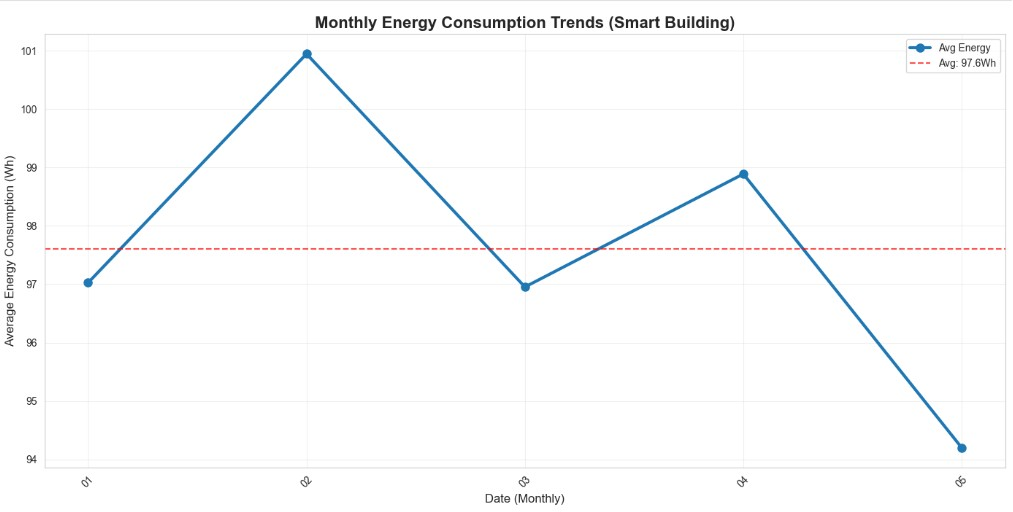

### 5.3 Correlation Analysis
Pearson correlation was computed at the daily level between:
- avg_daily_energy
- avg_daily_temp
- avg_daily_humidity

**Results:**
- **Energy vs. Temperature:** corr  ≈ **0.007**
- **Energy vs. Humidity:** small magnitude
- **Temp vs. Humidity:** corr  ≈**0.47** (warmer days tend to have lower relative humidity)
- Weather(temperature, humidity) explains almost none of the variation in daily appliance energy use.


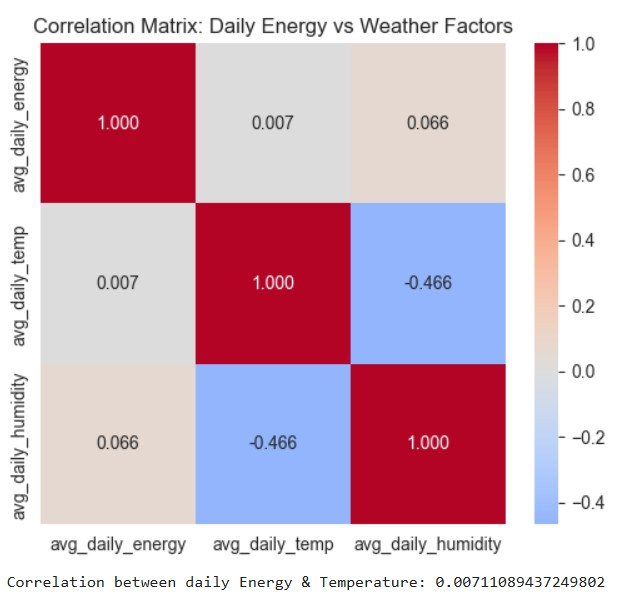

## 6. Predictive Modeling
### 6.1 Modeling Goal
To test whether a **simple, weather-based model** could predict daily appliance energy consumption. This mimics a smart-city use case where the city might want to forecast demand based only on weather forecasts.


### 6.2 Model Setup
- Features (X):
    - avg_daily_temp
    - avg_daily_humidity
- Target (y):
    - avg_daily_energy

### Train-test split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X = df_daily[['avg_daily_temp', 'avg_daily_humidity']]
y = df_daily['avg_daily_energy']

mask = ~X.isna().any(axis=1) & ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

coef_temp, coef_hum = model.coef_
intercept = model.intercept_

### 6.3 Model Performance
Results obtained:
- **Train R-Squared:** 0.015
- **Test R-Squared:** -0.051
- **Test MAE:** 23.6 Wh
- **Coefficients:**
    - Temperature: +0.48 Wh/°C
    - Humidity: +0.47 Wh/%RH
    - Intercept: 56.5 Wh

**Interpretations:**
- R-Squared = 0 (and slightly negative on test) means the model explains **almost none** of the variance.
- The model performs **worse than simply predicting the mean** daily energy for every day.
- Coefficients are small in magnitude; one degree change in temperature alters predicted energy by less than 1 Wh on average.

**An actual vs. predicted scatter plot for the test set shows:**
- Predicted values lying in a narrow band around the mean, regardless of actual energy.
- Confirms the **low predictive power** of weather-based features.

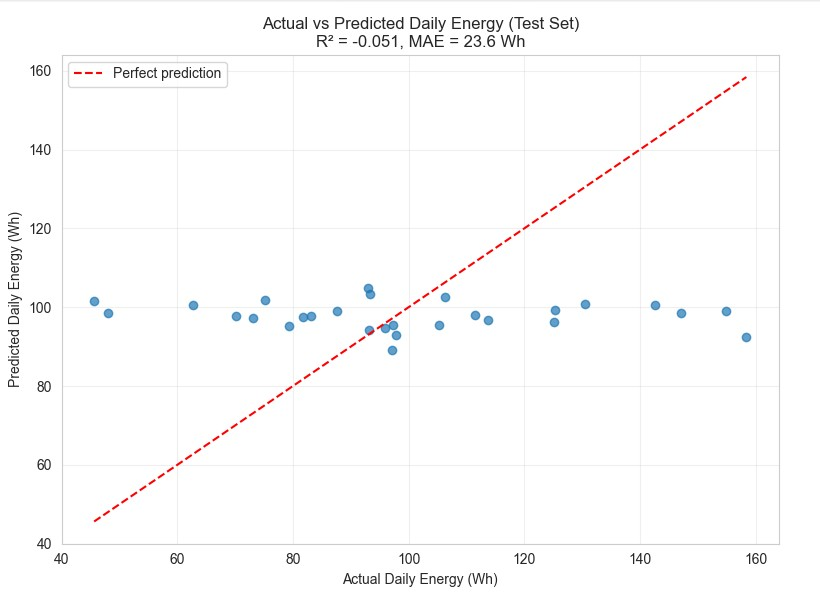

## 7. Business Interpretation
### 7.1 Core Insight
- Weather explains almost none of the variation in appliance-level energy consumption.
- Usage appears to be driven primarily by occupant behavior and schedules, not by temperature or humidity.

This has strong implications for smart‑city resource optimization:

- For **appliance loads:**
    - Focus on **behavioral interventions:** device scheduling, standby reduction, education, tariffs.
    - Use **occupancy data** (e.g., calendar, presence sensors) rather than weather alone.
- For **HVAC / heating loads** (not modeled here but typical in buildings):
    - Weather would likely be a much stronger driver. Separate models should be built for HVAC vs appliances.

### 7.2 Actionable Findings
1. **Weather‑only forecasting is not suitable** for appliance demand in this building. Resources should not be invested in weather‑only prediction engines for this load type.
2. **Top 10 high‑use days** (identified via a top‑N query/table) account for a disproportionately high share of total energy use and should be investigated individually (e.g., unusual occupancy, devices left on).
3. **Daily and monthly trends** show some seasonal structure, but the amplitude is modest. This indicates a relatively stable base load, again consistent with human patterns rather than environmental extremes.

## 8. Limitations & Future Work
### 8.1 Limitations
- **Single building, single load type:** Analysis is specific to one residential building’s appliance load; results may differ for HVAC or industrial loads.
- **Limited features:** Only external weather variables were used. No occupancy, device‑level, or calendar (weekday/weekend, holidays) features were included in the final model.
- **Simple model:** Only a linear regression model was tested. Non‑linear models might capture subtle effects but are unlikely to overcome the fundamentally weak correlation.

### 8.2 Future Work
1. **Add calendar and behavioral features**
    - Day of week, weekend/weekday, holidays.
    - Occupancy proxies (time of day patterns).
2. **Separate appliance and HVAC loads**
    - If sub‑metered data is available, build models for heating/cooling loads, where weather impact is expected to be stronger.
3. **Richer models**
    - Explore tree‑based models (Random Forest, Gradient Boosting) and compare performance to the baseline linear model.
4. **Operational integration**
    - Integrate with a real‑time dashboard (Power BI / Streamlit) to monitor energy KPIs and flag anomalous days for facility managers.


## 9. Conclusion
This project demonstrates an end‑to‑end data science workflow for smart‑city energy analysis:

1. **Ingestion & Modeling:** Raw IoT‑like measurements were organized into energy and weather tables in SQLite and joined using SQL.
2. **Aggregation & EDA:** Data were aggregated to daily and monthly levels, revealing overall consumption patterns.
3. **Statistical Analysis:** Correlation analysis showed that **appliance energy use** is almost independent of weather.
4. **Predictive Modeling:** A simple weather‑based linear model achieved **R² ≈ 0**, confirming that weather alone is not sufficient to forecast appliance loads.
5. **Business Recommendation:** Smart‑city optimization for this building should emphasize **behavioral and occupancy‑based strategies**, with weather‑driven models reserved for HVAC components.

The combination of SQL, Python, and Power BI provides a solid, reproducible framework that can be extended to other buildings, load types, and cities.